1. Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о
составах команд и повопросных результатах (поле mask в results.pkl). Для унификации
предлагаю:
* взять в тренировочный набор турниры с dateStart из 2019 года;
* в тестовый — турниры с dateStart из 2020 года.

In [1]:
import warnings
import gc
import pandas as pd
import pickle
from pandarallel import pandarallel


pandarallel.initialize()
warnings.filterwarnings('ignore')

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
with open('players.pkl', 'rb') as f:
    players = pickle.load(f)
players = pd.DataFrame(players).T.set_index('id').sort_index()
players.head(2)

,name,patronymic,surname
id,,,
1,Алексей,None,Абабилов
10,Игорь,,Абалов


In [3]:
with open('tournaments.pkl', 'rb') as f:
    tournaments = pickle.load(f)
tournaments = pd.DataFrame(tournaments).T.set_index('id').sort_index()
tournaments['year'] = pd.to_datetime(tournaments['dateStart']).map(lambda x: x.year)
tournaments = tournaments[tournaments.year >= 2019]
tournaments.head(2)

,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,year
id,,,,,,,,,
4628,Семь сорок,2020-12-30T16:00:00+03:00,2020-12-30T16:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",None,"[{'id': 7533, 'name': 'Денис', 'patronymic': '...",{'dateRequestsAllowedTo': '2020-12-30T23:55:00...,"{'1': 12, '2': 12, '3': 12}",2020
4772,Синхрон северных стран. Зимний выпуск,2019-01-05T19:00:00+03:00,2019-01-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019


In [4]:
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)
results = {key: val for key, val in results.items() if val!=[]}
correct_keys = {key: len([team['mask'] for team in val if
           ('mask' in team.keys()) and (not(team['mask'] is None))]) >= 1 for
                key, val in results.items() if val!=[]}
correct_keys = [key for key in correct_keys.keys() if correct_keys[key] == True]
results = pd.Series(results).loc[correct_keys]
results = results[results.index.isin(tournaments.index)]
gc.collect()
results.iloc[0][0]

{'team': {'id': 45556,
  'name': 'Рабочее название',
  'town': {'id': 285, 'name': 'Санкт-Петербург'}},
 'mask': '111111111011111110111111111100010010',
 'current': {'name': 'Рабочее название',
  'town': {'id': 285, 'name': 'Санкт-Петербург'}},
 'questionsTotal': 28,
 'synchRequest': {'id': 56392,
  'venue': {'id': 3030, 'name': 'Санкт-Петербург'}},
 'position': 1,
 'controversials': [{'id': 91169,
   'questionNumber': 15,
   'answer': 'Мьёльнир',
   'issuedAt': '2019-01-06T13:28:48+03:00',
   'status': 'A',
   'comment': '',
   'resolvedAt': '2019-01-06T15:25:54+03:00',
   'appealJuryComment': None}],
 'flags': [],
 'teamMembers': [{'flag': 'Б',
   'usedRating': 13507,
   'rating': 13507,
   'player': {'id': 6212,
    'name': 'Юрий',
    'patronymic': 'Яковлевич',
    'surname': 'Выменец'}},
  {'flag': 'Б',
   'usedRating': 10988,
   'rating': 13185,
   'player': {'id': 18332,
    'name': 'Александр',
    'patronymic': 'Витальевич',
    'surname': 'Либер'}},
  {'flag': 'Б',
   'usedRa

Случайным образом нашёлся Сергей Игоревич Николенко.

In [5]:
tournaments = tournaments[tournaments.index.isin(results.index)]
train_idx = tournaments[tournaments.year == 2019].index
test_idx = tournaments[tournaments.year == 2020].index

2. Постройте baseline-модель на основе линейной или логистической регрессии, которая
будет обучать рейтинг-лист игроков. Замечания и подсказки:
* повопросные результаты — это фактически результаты броска монетки, и их
предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель
должна это учитывать; скорее всего, модель должна будет явно обучать не только
силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные
результаты команды просто относятся к каждому из её игроков.

Исходя из замечаний и подсказок, будем считать, что каждый игрок независимо отвечает на текущий вопрос. Соответственно, команда даёт правильный ответ тогда и только тогда, когда хотя бы один из игроков дал правильный ответ(это не предположение, а утверждение). А с другой стороны мы не знаем, кто это был(скорее всего тот, у кого выше рейтинг). Поэтому можно сделать допущение, как будто каждый из игроков ответил/не ответил на текущий вопрос. В конце концов это имеет место на жизнь, ведь если слабый игрок играет в команде, которая всё время побеждает, может быть какие-нибудь его другие качества(мораль, настрой, рассудительность) позволяют команде отвечать правильно.

Теперь откуда взять сложность вопроса. На эти вопросы отвечают игроки. Про каждый вопрос известно, какие игроки ответили, а какие нет. Для решения этой задачи можно использовать логистическую регрессию. Сначала кажется, что если мы для каждого вопроса будем обучать модель, то и получим итоговую сложность. Если в модели признаком будет рейтинг, то можно найти коэффициент для данного вопроса. Однако как в таком случае обновлять рейтинг непонятно. Если признаком будет разряженный вектор - модель переобучится и просто запомнит как кто отвечал. Соответственно целевой переменной должен быть вектор ответов на все вопросы. В таком случае конкретный вопрос уже является признаком. Получается, что каждая строка матрицы признаков - это признак i игрока и j вопроса.


In [6]:
import numpy as np
from scipy.sparse import csr_array
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm

In [7]:
import gc

questions = {}
players = {}
max_idx = 0
col, y = [], []
team_row_id = []
for tour_idx in tqdm(train_idx):
    last_q_idx = -1
    for team in results.loc[tour_idx]:
        if not(team['mask'] is None):
            for q_index in range(len(team['mask'])):
                if q_index > last_q_idx:
                    questions[(tour_idx, q_index)] = max_idx
                    max_idx += 1
                    last_q_idx += 1
            for player in team['teamMembers']:
                player_id = int(player['player']['id'])
                if player_id not in players.keys():
                    players[player_id] = max_idx
                    max_idx += 1
                for q_index, q_val in enumerate(team['mask']):
                    if q_val in ['0', '1']:
                        col.append(players[player_id])
                        team_row_id.append('_'.join([str(team['team']['id']), str(tour_idx), str(q_index)]))
                        col.append(questions[(tour_idx, q_index)])
                        y.append(int(q_val))
row = [x // 2 for x in range(len(col))]
data = np.ones(len(col))
X = csr_array((data, (np.array(row), np.array(col))), shape=(len(y), max_idx))
row, col = None, None
gc.collect()

  0%|          | 0/675 [00:00<?, ?it/s]

18

In [8]:
lr = LogisticRegression(fit_intercept = True,random_state = 57,solver = 'saga')
lr.fit(X, y)

LogisticRegression(random_state=57, solver='saga')

In [9]:
ratings = pd.Series({player_id: lr.coef_[0][m_idx] for player_id, m_idx in players.items()})
ratings[ratings >= ratings[22799]].shape[0] / ratings.shape[0]

0.00016920187475677232

In [10]:
questions_ratings = pd.Series({question_id: lr.coef_[0][m_idx] for question_id, m_idx in questions.items()}, name='question_rating')
questions_ratings.describe()

count    33385.000000
mean        -0.000081
std          1.745984
min         -5.707873
25%         -1.177273
50%         -0.009408
75%          1.183167
max          6.098188
Name: question_rating, dtype: float64

Рейтинг получился адекватный. Сергей Игоревич Николенко в нём выше, чем 99.98 % игроков.

3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров.
Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь
неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны
эти предсказания сами по себе. Поэтому:
* предложите способ предсказать результаты нового турнира с известными
составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые
корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между
реальным ранжированием в результатах турнира и предсказанным моделью,
усреднённые по тестовому множеству турниров 1 .

Самый простой способ отранжировать команды - это сказать, что рейтинг команды - линейная комбинация рейтингов участников внутри. Одиночная свёртка. Но на этой будет влиять порядок игроков внутри команды. Поэтому можно, например, упорядочить игроков по убыванию рейтинга + отдельно рассмотреть рейтинг капитана.
Вопрос в том - как инициализировать эту линейную комбинацию. В прошлом пункте все игроки рассматривались и отвечали независимо. Исходя из нашей модели игрок даст правильный ответ, если его рейтинг превышает некоторый порог.
Какие есть возможности оценить эту линейную комбинацию? Можно использовать ту же задачу классификации, только вместо указания конкретного человека указывать рейтинг всех членов его команды, а вместо вопроса указать сложность.

In [11]:
r_len = []
for tour_idx in tqdm(train_idx):
    for team in results.loc[tour_idx]:
        if not(team['mask'] is None):
            player_ids = [int(player['player']['id']) for player in team['teamMembers']]
            player_ratings = ratings.loc[player_ids]
            r_len.append(len(player_ratings))
pd.Series(r_len).value_counts()

  0%|          | 0/675 [00:00<?, ?it/s]

6     39754
5     20357
4     12181
3      5789
7      2935
2      2650
8      1270
1       557
9       520
10      223
0       104
11       79
12       43
13       16
14       10
15        5
16        3
17        2
21        1
dtype: int64

Видно, что в целом, можно оценивать рейтинг по 6 игрокам. Если меньше - можно западдить. Лишних игроков отрежем:)

In [12]:
mask = []
for tour_idx in tqdm(train_idx):
    for team in results.loc[tour_idx]:
        if not(team['mask'] is None):
            player_ids = [int(player['player']['id']) for player in team['teamMembers']]
            for q_index, q_val in enumerate(team['mask']):
                if (q_val in ['0', '1']) and ((tour_idx, q_index) in questions_ratings.index):
                    mask.append([(tour_idx, q_index), int(q_val)] + player_ids)
mask = pd.DataFrame(mask, columns = ['question', 'y'] + [f'player{x}' for x in range(21)])
mask = mask.dropna(subset=['player0'])
mask

  0%|          | 0/675 [00:00<?, ?it/s]

,question,y,player0,player1,player2,player3,player4,player5,player6,player7,...,player11,player12,player13,player14,player15,player16,player17,player18,player19,player20
0,"(4772, 0)",1,6212.0,18332.0,18036.0,22799.0,15456.0,26089.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(4772, 1)",1,6212.0,18332.0,18036.0,22799.0,15456.0,26089.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(4772, 2)",1,6212.0,18332.0,18036.0,22799.0,15456.0,26089.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(4772, 3)",1,6212.0,18332.0,18036.0,22799.0,15456.0,26089.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"(4772, 4)",1,6212.0,18332.0,18036.0,22799.0,15456.0,26089.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3807482,"(6255, 31)",0,217153.0,217154.0,217155.0,217156.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3807483,"(6255, 32)",0,217153.0,217154.0,217155.0,217156.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3807484,"(6255, 33)",0,217153.0,217154.0,217155.0,217156.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3807485,"(6255, 34)",0,217153.0,217154.0,217155.0,217156.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
ratings_dict = ratings.to_dict()
questions_ratings_dict = questions_ratings.to_dict()
y_ratings = mask['y']
q_scores = mask.question.map(lambda x: questions_ratings_dict[x])
team_scores = mask[[f'player{x}' for x in range(21)]].parallel_applymap(
    lambda x: ratings_dict[x] if not np.isnan(x) else None, axis=1)
team_scores = pd.DataFrame(team_scores.parallel_apply(
    lambda x: sorted(x.dropna().values, reverse=True)[:6], axis=1)
                           .values.tolist(), index=q_scores.index).fillna(axis=1, method='ffill')
X_ratings = pd.concat([team_scores, q_scores], axis=1)

In [14]:
## depricated ##

# X_train = []
# for tour_idx in tqdm(train_idx):
#     for team in results.loc[tour_idx]:
#         if not(team['mask'] is None):
#             player_ids = [int(player['player']['id']) for player in team['teamMembers']]
#             player_ratings = ratings.loc[player_ids].sort_values(ascending=False).iloc[:6].tolist()
#             if len(player_ratings) > 0:
#                 while len(player_ratings) < 6:
#                     player_ratings.append(player_ratings[-1])
#                 for q_index, q_val in enumerate(team['mask']):
#                     if (q_val in ['0', '1']) and ((tour_idx, q_index) in questions_ratings.index):
#                         X_train.append(player_ratings + [questions_ratings.loc[(tour_idx, q_index)], int(q_val)])
# X_train = pd.DataFrame(X_train, columns=['player1', 'player2','player3','player4','player5','player6','question','y']).dropna(subset=['question'])
# X_train.head()

In [15]:
lr_teams = LogisticRegression(fit_intercept = True, random_state = 57,solver = 'saga')
lr_teams.fit(X_ratings, y_ratings)
lr_teams.coef_[0]

array([0.20836541, 0.21829504, 0.17785539, 0.21220936, 0.19721631,
       0.0683978 , 1.04419533])

Видно, что в целом это похоже на сумму, за исключением того, что 6 игрок чаще всего не нужен. Думаю, результаты получились столь близкими из-за близости рейтингов игроков одной команды

In [16]:
test_results = []
for tour_idx in test_idx:
    for team in results.loc[tour_idx]:
        player_ids = [int(player['player']['id']) for player in team['teamMembers'] if int(player['player']['id']) in ratings.index]
        if len(player_ids) > 0:
            player_ratings = ratings.loc[player_ids].sort_values(ascending=False).iloc[:6].tolist()
            while len(player_ratings) < 6:
                player_ratings.append(player_ratings[-1])
            team_rating = lr_teams.coef_[0][:6] @ np.array(player_ratings)
            test_results.append([tour_idx, team['position'], team_rating])
test_results = pd.DataFrame(test_results, columns=['tournament_id', 'team_position', 'team_rating'])
test_results.head()

,tournament_id,team_position,team_rating
0,4957,1.0,4.225963
1,4957,2.0,3.188382
2,4957,3.0,3.057432
3,4957,4.0,3.581016
4,4957,5.5,3.487737


In [17]:
from scipy.stats import spearmanr, kendalltau

test_results.groupby('tournament_id').apply(lambda x: -spearmanr(x.team_position, x.team_rating)[0]).mean(), \
test_results.groupby('tournament_id').apply(lambda x: -kendalltau(x.team_position, x.team_rating)[0]).mean()

(0.7923564192508571, 0.6369316439646432)

4. Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
* предложите способ учитывать то, что на вопрос отвечают сразу несколько
игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать
упрощающие предположения, но теперь переменные “игрок X ответил на вопрос
Y” при условии данных должны стать зависимыми для игроков одной и той же
команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем
растут (скорее всего, ненамного, но расти должны), выберите лучшую модель,
используя целевые метрики.

Теперь задача такая - вся команда совместно отвечает на вопрос. Если бы мы знали, какой из игроков может ответить на вопрос - задача бы легко решалась, как мы уже делали раньше. Что точно можно утверждать - так это то, что если задача не решена - она не решена никем.

С другой стороны нам необходимо использовать EM алгоритм. M шаг - максимизация правдоподобия. Мы делаем его в момент обучения нашей логистической регрессии. Во время её обучения мы как раз-таки делали предположения о том, что все участники команды способны её решить, т.е. скрытыми переменными является информация о том, способен ли каждый конкретный участник решить данную задачу. Эта самая способность исчисляется вероятностью. Проще всего посчитать вероятность того, что команда не решит задачу. Она равна(исходя из наших упрощений)
$$P(y = 0 | x_i_0, x_i_1, ...) = \prod_{j \in Q}P(y = 0 | x_i_j)$$
Соответственно, это означает то, что обучив модель(переходим на E шаг), мы теперь можем оценить вероятность правильного ответа команды как
$$P(y = 1 | x_i_0, x_i_1, ...) = 1 - P(y = 0 | x_i_0, x_i_1, ...) = 1 - \prod_{j \in Q}P(y = 0 | x_i_j)$$
А теперь снова перейдём к нашему упрощению и получим:
$$P(y = 1 | x_i_j) 	\cong P(y = 1 | x_i_0, x_i_1, ...) = 1 - P(y = 0 | x_i_0, x_i_1, ...) = 1 - \prod_{j \in Q}P(y = 0 | x_i_j)$$
Ввиду использования sсikit-learn, будем подавать эту вероятность в качестве весов для модели на m-шаге

In [18]:
def m_step(probas):
    lr = LogisticRegression(fit_intercept = True,random_state = 57,solver = 'saga', n_jobs=6)
    lr.fit(X, y, probas)
    return lr


def e_step(lr):
    # concat team_question with the prediction
    probas = pd.concat([pd.Series(team_row_id), pd.Series(lr.predict_proba(X)[:, 0])], axis=1).sort_values(by=[0])
    # aggregate score from team+q
    probas = 1 - probas.groupby(0).agg('prod')
    probas = probas.loc[team_row_id].values
    probas = probas[:, 0] * np.array(y)
    probas += (1 - np.array(y))
    return probas


def update_rating(lr):
    ratings = pd.Series({player_id: lr.coef_[0][m_idx] for player_id, m_idx in players.items()})
    questions_ratings = pd.Series({question_id: lr.coef_[0][m_idx] for question_id, m_idx in questions.items()})
    ratings_dict = ratings.to_dict()
    questions_ratings_dict = questions_ratings.to_dict()
    q_scores = mask.question.map(lambda x: questions_ratings_dict[x])
    team_scores = mask[[f'player{x}' for x in range(21)]].parallel_applymap(
        lambda x: ratings_dict[x] if not np.isnan(x) else None, axis=1)
    team_scores = pd.DataFrame(team_scores.parallel_apply(
    lambda x: sorted(x.dropna().values, reverse=True)[:6], axis=1)
                           .values.tolist(), index=q_scores.index).fillna(axis=1, method='ffill')
    X_ratings = pd.concat([team_scores, q_scores], axis=1)
    lr_teams = LogisticRegression(fit_intercept = True, random_state = 57,solver = 'saga')
    lr_teams.fit(X_ratings, y_ratings)
    return ratings, questions_ratings, lr_teams.coef_[0]


def calc_test_metrics(teams_coef, ratings):
    test_results = []
    for tour_idx in test_idx:
        for team in results.loc[tour_idx]:
            player_ids = [int(player['player']['id']) for player in team['teamMembers'] if int(player['player']['id']) in ratings.index]
            if len(player_ids) > 0:
                player_ratings = ratings.loc[player_ids].sort_values(ascending=False).iloc[:6].tolist()
                while len(player_ratings) < 6:
                    player_ratings.append(player_ratings[-1])
                team_rating = teams_coef[:6] @ np.array(player_ratings)
                test_results.append([tour_idx, team['position'], team_rating])
    test_results = pd.DataFrame(test_results, columns=['tournament_id', 'team_position', 'team_rating'])
    spearman_score = test_results.groupby('tournament_id').apply(lambda x: -spearmanr(x.team_position, x.team_rating)[0]).mean()
    kendall_score = test_results.groupby('tournament_id').apply(lambda x: -kendalltau(x.team_position, x.team_rating)[0]).mean()
    return spearman_score, kendall_score


def pipeline(iterations=20):
    best_score = 0
    best_ratings = None
    weights = np.ones(len(y))
    for _ in tqdm(range(iterations)):
        lr = m_step(weights)
        ratings, questions_ratings, teams_coef = update_rating(lr)
        score1, score2 = calc_test_metrics(teams_coef, ratings)
        print(f'Coefficient of correlation Spearman: {score1}, Kendall {score2}')
        if score1 + score2 > best_score:
            best_score = score1 + score2
            best_ratings = (lr, ratings, questions_ratings, teams_coef)
        weights = e_step(lr)
    return best_ratings

In [19]:
lr, ratings, questions_ratings, teams_coef = pipeline()

  0%|          | 0/20 [00:00<?, ?it/s]

Coefficient of correlation Spearman: 0.7923564192508571, Kendall 0.6369316439646432
Coefficient of correlation Spearman: 0.7917345518885482, Kendall 0.6351449388016083
Coefficient of correlation Spearman: 0.790879300369605, Kendall 0.6343097167373191
Coefficient of correlation Spearman: 0.791304144111033, Kendall 0.6352235210547711
Coefficient of correlation Spearman: 0.78960619571955, Kendall 0.6338777253679475
Coefficient of correlation Spearman: 0.7895407585774119, Kendall 0.6339277687906102
Coefficient of correlation Spearman: 0.7894009139878527, Kendall 0.6338491738891545
Coefficient of correlation Spearman: 0.7893469477663526, Kendall 0.6337827819692138
Coefficient of correlation Spearman: 0.7893447813762233, Kendall 0.6337638517814385
Coefficient of correlation Spearman: 0.7893260777485663, Kendall 0.6337378654963515
Coefficient of correlation Spearman: 0.7893488886524297, Kendall 0.6337789102541942
Coefficient of correlation Spearman: 0.7893604149882094, Kendall 0.6337813819121

In [20]:
ratings[ratings >= ratings[22799]].shape[0] / ratings.shape[0]

0.00016920187475677232

Вывод:

EM алгоритм не справился. Лучшая модель так и осталась с первой итерации.

5. А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов.
Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть
сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно:
постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе
вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

In [68]:
tournamets_rating = questions_ratings.reset_index().groupby('level_0')[0].agg(['mean', 'max', 'min', 'std'])
tournaments.merge(tournamets_rating, left_index=True, right_index=True, how='inner').sort_values(by='max')[['name', 'mean', 'max', 'min']]

,name,mean,max,min
6149,Чемпионат Санкт-Петербурга. Первая лига,-4.443113,-4.443108,-4.443115
5946,Чемпионат Мира. Этап 3. Группа В,-1.368447,0.258438,-4.659388
5928,Угрюмый Ёрш,-2.284861,0.318945,-4.979611
6102,One ring - async,0.030130,0.408941,-0.393243
5947,Чемпионат Мира. Этап 3. Группа С,-1.355473,0.538885,-4.069982
...,...,...,...,...
5012,Школьный Синхрон-lite. Выпуск 2.5,2.084373,5.827135,-1.197565
5644,Школьный чемпионат России,1.015975,5.834918,-2.922986
5013,(а)Синхрон-lite. Лига старта. Эпизод V,2.401641,5.950614,-1.324158
5702,(а)Синхрон-lite. Лига старта. Эпизод IX,2.162632,6.078022,-1.579863


In [69]:
tournaments.merge(tournamets_rating, left_index=True, right_index=True, how='inner').sort_values(by='mean')[['name', 'mean', 'max', 'min']]

,name,mean,max,min
6149,Чемпионат Санкт-Петербурга. Первая лига,-4.443113,-4.443108,-4.443115
5928,Угрюмый Ёрш,-2.284861,0.318945,-4.979611
5159,Первенство правого полушария,-2.060456,2.335225,-5.537197
5684,Синхрон высшей лиги Москвы,-2.025317,1.127712,-4.741303
6101,Воображаемый музей,-1.973223,1.200191,-4.485349
...,...,...,...,...
5438,Синхрон Лиги Разума,2.141110,3.831741,-1.473219
5698,(а)Синхрон-lite. Лига старта. Эпизод VII,2.145508,5.623299,-0.362648
5702,(а)Синхрон-lite. Лига старта. Эпизод IX,2.162632,6.078022,-1.579863
5009,(а)Синхрон-lite. Лига старта. Эпизод III,2.202455,4.894104,-1.187950


In [70]:
tournaments.merge(tournamets_rating, left_index=True, right_index=True, how='inner').sort_values(by='min')[['name', 'mean', 'max', 'min']]

,name,mean,max,min
5186,VERSUS: Коробейников vs. Матвеев,-1.512627,2.353458,-5.707873
5465,Чемпионат России,-1.543163,1.972370,-5.575786
5159,Первенство правого полушария,-2.060456,2.335225,-5.537197
5780,Кубок ярмарок,-1.059003,3.699472,-5.502984
5774,Синхрон Кеста,-1.024460,1.396999,-5.356996
...,...,...,...,...
6102,One ring - async,0.030130,0.408941,-0.393243
5698,(а)Синхрон-lite. Лига старта. Эпизод VII,2.145508,5.623299,-0.362648
5313,(а)Синхрон-lite. Лига старта. Эпизод VI,1.915013,5.509185,-0.335386
5955,Школьная лига. III тур.,1.982821,5.243693,-0.285767


Вывод:

Наша рейтинг система игроков составлена таким образом, что чем выше рейтинг у игрока, тем с большей вероятностью он правильно ответит на вопрос. С другой стороны, чем выше рейтинг у вопроса, тем выше вероятность, что на него ответят, т.е. самые сложные вопросы имеют наименьший рейтинг.
Придумать хорошее ранжирование турниров не так просто. Потому что турнир задаётся распределением вопросов, которые там задаются. Простые критерии, которые приходят в голову - самый простой вопрос, самый сложный, и среднее значение. На первые две метрики могут сильно повлиять выбросы.

<AxesSubplot:ylabel='Density'>

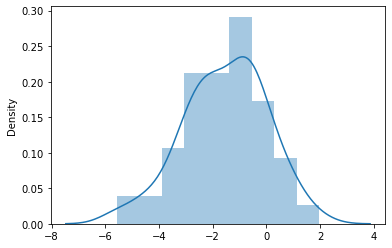

In [60]:
import seaborn as sns
# В качестве примера построим какое распределение нам напоминают вопросы с чемпионата России
sns.distplot(questions_ratings.loc[5465, :])

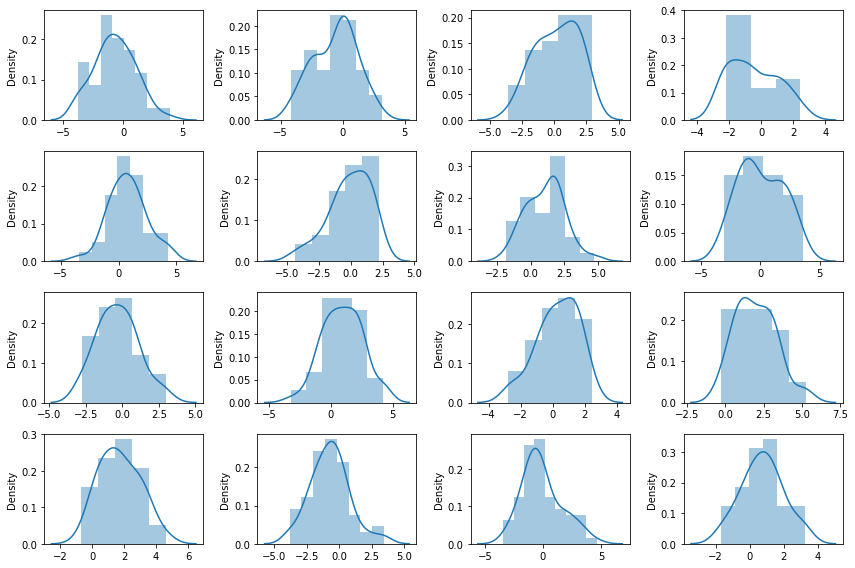

In [67]:
import matplotlib.pyplot as plt


indexes = tournaments.merge(tournamets_rating, left_index=True, right_index=True, how='inner').sort_values(by='min')[['name', 'mean', 'max', 'min']].index
sample = np.random.choice(indexes, 16)
plt.figure(figsize=(12, 8))
for idx, tour in enumerate(sample, 1):
    plt.subplot(4, 4, idx)
    image = sns.distplot(questions_ratings.loc[tour, :])
    # plt.imshow(image)

plt.tight_layout()
plt.show()

Кажется, что распределение похоже на нормальное, поэтому турнир задаётся средним и дисперсией вопросов. Можно, вычесть одну значение одного std из среднего и получить ожидаемый уровень сложных вопросов с турнира. Пусть будет решающим критерием.

In [75]:
final_tournament_rating = tournaments.merge(tournamets_rating, left_index=True, right_index=True, how='inner').sort_values(
    by='min')[['name', 'mean', 'std']]
final_tournament_rating.set_index('name', inplace=True)
final_tournament_rating['rating'] = final_tournament_rating['mean'] - final_tournament_rating['std']
final_tournament_rating.sort_values(by='rating')

,mean,std,rating
name,,,
Чемпионат Санкт-Петербурга. Первая лига,-4.443113,9.465984e-07,-4.443114
Первенство правого полушария,-2.060456,1.801905e+00,-3.862361
Угрюмый Ёрш,-2.284861,1.402664e+00,-3.687525
Воображаемый музей,-1.973223,1.673564e+00,-3.646787
Кубок городов,-1.718960,1.854595e+00,-3.573555
...,...,...,...
Синхрон Лиги Разума,2.141110,1.416395e+00,0.724715
(а)Синхрон-lite. Лига старта. Эпизод III,2.202455,1.359582e+00,0.842872
Школьная лига. I тур.,2.057144,1.177092e+00,0.880052


In [77]:
final_tournament_rating.sort_values(by='rating').head(20)

,mean,std,rating
name,,,
Чемпионат Санкт-Петербурга. Первая лига,-4.443113,9.465984e-07,-4.443114
Первенство правого полушария,-2.060456,1.801905e+00,-3.862361
Угрюмый Ёрш,-2.284861,1.402664e+00,-3.687525
Воображаемый музей,-1.973223,1.673564e+00,-3.646787
Кубок городов,-1.718960,1.854595e+00,-3.573555
Синхрон высшей лиги Москвы,-2.025317,1.544579e+00,-3.569896
Кубок Москвы,-1.468135,1.886695e+00,-3.354830
Записки охотника,-1.796557,1.522405e+00,-3.318962
Знание – Сила VI,-1.667953,1.594311e+00,-3.262265


Победил Чемпионат Санкт-Петербурга. А школьная лига, ожидаемо, оказалась самым простым турниром.
С одной стороны кажется странным, что чемпионат мира не оказался в самом топе, но наверное это объясняется тем, что от некоторых стран могут быть априори не самые сильные коллективы, поэтому и вопросы должны встречаться соответствующие.

6. Бонус: постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с
именами игроков напишите общее число вопросов, которое они сыграли. Скорее всего,
вы увидите, что топ занят игроками, которые сыграли совсем мало вопросов, около 100
или даже меньше; если вы поищете их в официальном рейтинге ЧГК, вы увидите, что
это какие-то непонятные ноунеймы. В baseline-модели, скорее всего, такой эффект
будет гораздо слабее.
Это естественное свойство модели: за счёт EM-схемы влияние 1-2 удачно сыгранных
турниров будет только усиливаться, потому что неудачных турниров, чтобы его
компенсировать, у этих игроков нет. Более того, это не мешает метрикам качества,
потому что если эти игроки сыграли всего 1-2 турнира в 2019-м, скорее всего они ничего
или очень мало сыграли и в 2020, и их рейтинги никак не влияют на качество тестовых
предсказаний. Но для реального рейтинга такое свойство, конечно, было бы крайне
нежелательным. Давайте попробуем его исправить:
* сначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в
одном турнире их обычно 30-50;
* можно ли просто выбросить игроков, которые мало играли, и переобучить
модель? почему? предложите, как нужно изменить модель, чтобы не учитывать
слишком мало сыгравших, и переобучите модель;
* но всё-таки это не слишком хорошее решение: если выбрать маленькую отсечку,
будут ноунеймы в топе, а если большую, то получится, что у нового игрока
слишком долго не будет рейтинга; скорее всего, никакой “золотой середины” тут
не получится;
* предложите более концептуальное решение для топа игроков в рейтинг-листе;
если получится, реализуйте его на практике (за это уж точно будут серьёзные
бонусные баллы)

7. Бонус: игроки со временем учатся играть лучше (а иногда бывает и наоборот). А в нашей
модели получается, что первые неудачные турниры новичка будут тянуть его рейтинг
вниз всю жизнь — это нехорошо, рейтинг должен быть достаточно гибким и иметь
возможность меняться даже у игроков, отыгравших сотни турниров. Давайте попробуем
этого добиться:
* если хватит вычислительных ресурсов, сначала сделайте baseline совсем без
таких схем, обучив рейтинги на всех турнирах с повопросными результатами, а не
только на турнирах 2019 года; улучшилось ли качество предсказаний на 2020?
* одну схему со временем мы уже использовали: брали для обучения только
последний год турниров; примерно так делают, например, в теннисной
чемпионской гонке; у этой схемы есть свои преимущества, но есть и недостатки
(например, достаточно мало играть год, чтобы полностью пропасть из рейтинга);
* предложите варианты базовой модели или алгоритма её обучения, которые
могли бы реализовать изменения рейтинга со временем; если получится,
реализуйте их на практике, проверьте, улучшатся ли предсказания на 2020.